In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import pickle
from sklearn.metrics import mean_squared_error

In [18]:
df = pd.read_excel('spalling.xlsx', index_col=0)

In [37]:
df_spall = df.loc[df['spalling']!=0]
# df_spall = df_spall.loc[df['firecurve']=='std']
df_spall = df_spall.drop('firecurve', axis=1)
df_spall = df_spall.drop('weightloss', axis=1)
df_spall = df_spall.drop('time', axis=1)
df_spall = df_spall.drop('Age', axis=1)
df_spall = df_spall.drop('load', axis=1)
df_use = df_spall
df_use.drop(df_use[df_use.moisture == '-'].index, inplace=True)

In [38]:
df_use.tail()

,spalling,stress,moisture,Compressive strength
name,,,,
45.4,16,8.21,4.8,82
45.6,20,8.64,4.8,82
45.7,22,7.86,4.6,78
45.8,20,3.88,4.6,78
53.1,4,5.20,4.3,52


In [39]:
X = df_use.drop('spalling', axis = 1)
y = df_use['spalling']

In [40]:
X = X.to_numpy()
y = y.to_numpy()

kf = KFold(n_splits=4,shuffle=True)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [41]:
LOWER_ALPHA = 0.1
MIDDLE_ALPHA = 0.5
UPPER_ALPHA = 0.9

In [42]:
lower_model = GradientBoostingRegressor(loss="quantile",                   
                                        alpha=LOWER_ALPHA)
# The mid model will use the default loss
mid_model = GradientBoostingRegressor(loss="ls")
upper_model = GradientBoostingRegressor(loss="quantile",
                                        alpha=UPPER_ALPHA)

In [43]:
# Fit models
lower_model.fit(X_train, y_train)
mid_model.fit(X_train, y_train)
upper_model.fit(X_train, y_train)
# Record actual values on test set
predictions = pd.DataFrame(y_test)
# Predict
predictions['lower'] = lower_model.predict(X_test)
predictions['mid'] = mid_model.predict(X_test)
predictions['upper'] = upper_model.predict(X_test)

In [44]:
predictions = pd.DataFrame(y_test)

In [45]:
predictions['upper'] = upper_model.predict(X_test)
X_test[:1]

array([[6.34, 4.5, 63]], dtype=object)

In [46]:
d = {'y_test': y_test, 'predictions': predictions['upper']}
df_show = pd.DataFrame(data=d)

In [47]:
df_show

,y_test,predictions
0,17,30.672722
1,33,74.173321
2,20,27.927008
3,27,34.166219
4,21,44.095394
5,54,44.095394
6,41,44.003451
7,50,57.056782
8,67,74.536461
9,30,43.151869


In [48]:
df_show['under'] = df_show['predictions']>df_show['y_test']

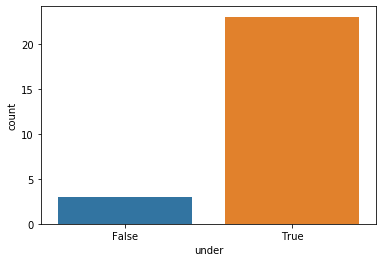

In [49]:
ax = sns.countplot(x="under", data=df_show)

In [52]:
d = {'stress': [7], 'moisture': [5.9], 'Compressive strength': [60]}
d_test = pd.DataFrame(data=d)

print('Your slab will with a 90 percent certainty not spall more than: ')  
print(str(int(upper_model.predict(d_test))) + ' mm')

Your slab will with a 90 percent certainty not spall more than: 
71 mm


In [60]:
rms = mean_squared_error(df_show['y_test'],df_show['predictions'], squared=False)
rms

24.545531339838725

In [61]:
with open("regression_model.pickle", "wb") as file:
    pickle.dump(upper_model, file)
print ("Model saved.")

Model saved.
